In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CEM_DE

In [ ]:
import numpy as np
from tqdm import tqdm
import yaml
import os

In [ ]:
from library.benchmark import Benchmark
from library.utils import tuple_all_sublist, make_gif_for_es, set_random_seed
from library.zip2 import zip2
from library import cem
CEM = cem.solve

In [ ]:
def Sphere():
    def forward(x):
        x = np.array(x)
        res = np.sum(x**2)
        return res

    return Benchmark(
            name = 'Sphere',
            forward = forward,
            lower_bound = -5.12,
            upper_bound = 5.12,
            global_minima = np.zeros(2),
            f_x_star = 0.0,
        )
        
Sphere = Sphere()
for it in Sphere.__dict__.items():
    print(it)
print(f'Sphere(Sphere.global_minima): {Sphere(Sphere.global_minima)}')
Sphere.show()

In [ ]:
def Zakharov():
    def forward(x):
        x = np.array(x)
        d = len(x)
        temp = np.sum(0.5 * np.arange(1, d+1) * x)
        res = np.sum(x**2) + temp**2 + temp**4
        return res
    
    return Benchmark(
            name = 'Zakharov',
            forward = forward,
            lower_bound = -5,
            upper_bound = 10,
            global_minima = np.zeros(2),
            f_x_star = 0,
        )
        
Zakharov = Zakharov()
for it in Zakharov.__dict__.items():
    print(it)
print(f'Zakharov(Zakharov.global_minima): {Zakharov(Zakharov.global_minima)}')
Zakharov.show(-10, 10)

('forward', <function Rosenbrock.<locals>.forward at 0x7f14fe22c4d0>)
('lower_bound', -5)
('upper_bound', 10)
('global_minima', array([1., 1.]))
('f_x_star', 0)
('name', 'Rosenbrock')
Rosenbrock(Rosenbrock.global_minima): 0.0


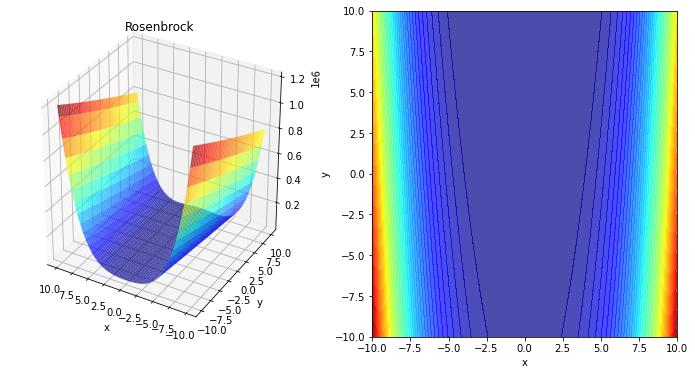

In [ ]:
def Rosenbrock():
    def forward(x):
        x = np.array(x)
        res = 100 * (x[1:] - x[:-1]**2)**2 + (x[:-1] - 1)**2
        res = np.sum(res)
        return res
    
    return Benchmark(
            name = 'Rosenbrock',
            forward = forward,
            lower_bound = -5,
            upper_bound = 10,
            global_minima = np.ones(2),
            f_x_star = 0,
        )
        
Rosenbrock = Rosenbrock()
for it in Rosenbrock.__dict__.items():
    print(it)
print(f'Rosenbrock(Rosenbrock.global_minima): {Rosenbrock(Rosenbrock.global_minima)}')
Rosenbrock.show(-10, 10)

('forward', <function Michalewicz.<locals>.forward at 0x7f14ff38e680>)
('lower_bound', 0)
('upper_bound', 3.141592653589793)
('global_minima', array([2.2 , 1.57]))
('f_x_star', -1.8013)
('name', 'Michalewicz')
Michalewicz(Michalewicz.global_minima): -1.801140718473825


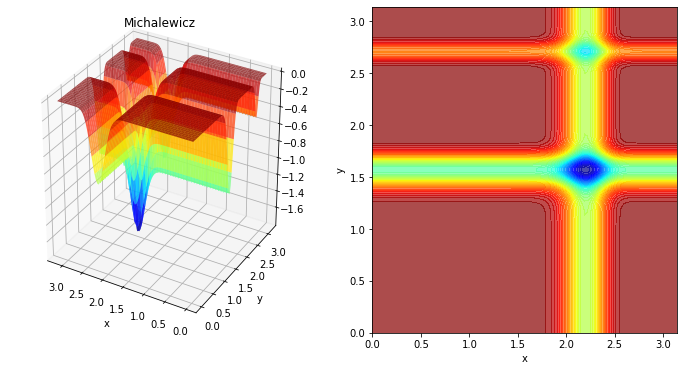

In [ ]:
def Michalewicz():
    def forward(x, m=10):
        x = np.array(x)
        d = len(x)
        res = - np.sin(x) * np.sin(np.arange(1, d+1) * x**2 / np.pi)**(2*m)
        res = np.sum(res)
        return res
    
    return Benchmark(
            name = 'Michalewicz',
            forward = forward,
            lower_bound = 0,
            upper_bound = np.pi,
            global_minima = np.array((2.20, 1.57)),
            f_x_star = -1.8013,
        )
        
Michalewicz = Michalewicz()
for it in Michalewicz.__dict__.items():
    print(it)
print(f'Michalewicz(Michalewicz.global_minima): {Michalewicz(Michalewicz.global_minima)}')
Michalewicz.show()

('forward', <function Ackley.<locals>.forward at 0x7f14ff511b00>)
('lower_bound', -32.768)
('upper_bound', 32.768)
('global_minima', array([0., 0.]))
('f_x_star', 0)
('name', 'Ackley')
Ackley(Ackley.global_minima): 0.0


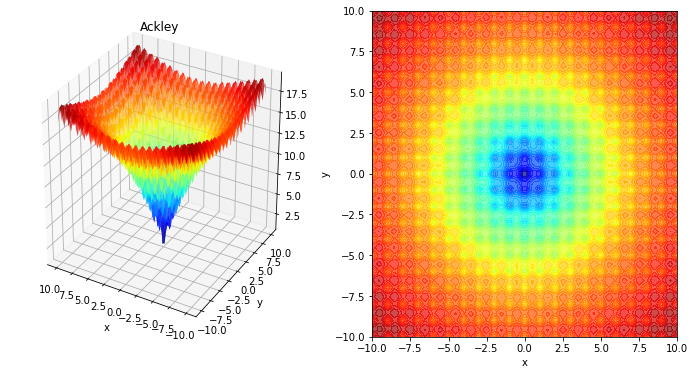

In [ ]:
def Ackley():
    def forward(x, a=20, b=0.2, c=2*np.pi):
        x = np.array(x)
        d = len(x)
        res = - a * np.exp(- b * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(c * x)) / d) + np.e + a
        return res
    
    return Benchmark(
            name = 'Ackley',
            forward = forward,
            lower_bound = -32.768,
            upper_bound = 32.768,
            global_minima = np.zeros(2),
            f_x_star = 0,
        )
        
Ackley = Ackley()
for it in Ackley.__dict__.items():
    print(it)
print(f'Ackley(Ackley.global_minima): {Ackley(Ackley.global_minima)}')
Ackley.show(-10, 10)

In [ ]:
def DE(
    fobj,
    num_params,
    pop_size,
    max_eval_cals,
    bounds = [float('-inf'), float('+inf')],
    range_init = [-1, 1],
    F_scale=0.8,
    cross_prob=0.7,
    verbose=0,
    log_mode=1,
    ):

    bounds = np.array(bounds)
    if bounds.shape == (2,):
        bounds = np.ones((num_params, 2)) * bounds
    lower_bound = bounds[:, 0]
    upper_bound = bounds[:, 1]

    range_init = np.array(range_init)
    if range_init.shape == (2,):
        range_init = np.ones((num_params, 2)) * range_init
    lower_range_init = range_init[:, 0]
    upper_range_init = range_init[:, 1]
    diff = upper_range_init - lower_range_init
    pop = lower_range_init + diff * np.random.rand(pop_size, num_params)

    generation = 0
    fitness = np.asarray([fobj(ind) for ind in pop])
    num_eval_cals = pop_size

    best_idx = np.argmin(fitness)

    best = pop[best_idx]

    results = []
    all_pops = []
    results.append((np.copy(best), fitness[best_idx], generation, num_eval_cals))
    if log_mode == 3:
        all_pops.append(np.copy(pop))

    while num_eval_cals + pop_size <= max_eval_cals:
        generation += 1
        for j in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F_scale * (b-c), lower_bound, upper_bound)

            cross_points = np.random.rand(num_params) < cross_prob
            if not np.any(cross_points):
                cross_points[np.random.randint(0, num_params)] = True
            
            trial = np.where(cross_points, mutant, pop[j])

            f = fobj(trial)
            num_eval_cals += 1

            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial
        
        results.append((np.copy(best), fitness[best_idx], generation, num_eval_cals))
        if log_mode == 3:
            all_pops.append(np.copy(pop))

    return results, all_pops

In [ ]:
algorithms = ['CEM', 'DE']
bechmarks = ['Sphere', 'Zakharov', 'Rosenbrock', 'Michalewicz', 'Ackley']
dimensions = [2, 10]
pop_sizes = [1024, 512, 256, 128, 64, 32]
seeds = list(range(20520864, 20520864 + 10))
max_eval_cals = {
    2: 100_000,
    10: 1_000_000,
}
log_folder = 'log'
gif_folder = 'gif'

In [ ]:
for algo_name, fobj_name, d, pop_size, seed in tqdm(zip2(algorithms, bechmarks, dimensions, pop_sizes, seeds, random_order=True)):
    key = (algo_name, fobj_name, d, pop_size, seed)
    file_name = '.'.join(map(str, key))
    log_path = os.path.join(log_folder, file_name + '.yaml')
    if os.path.exists(log_path):
        with open(log_path, 'rt') as f:
            log_data = yaml.unsafe_load(f)

        if 'best_ind' in log_data[key].keys() \
        and 'best_fitness' in log_data[key].keys() \
        and 'generation' in log_data[key].keys() \
        and 'num_eval_cals' in log_data[key].keys():
            best_ind = log_data[key]['best_ind']
            best_fitness = log_data[key]['best_fitness']
            generation = log_data[key]['generation']
            num_eval_cals = log_data[key]['num_eval_cals']

            if len(generation) == len(best_ind) \
            and len(generation) == len(best_fitness) \
            and len(generation) == len(num_eval_cals):

                if len(num_eval_cals) >= 3 \
                and (num_eval_cals[-1] + (num_eval_cals[-2] - num_eval_cals[-3])) > max_eval_cals[d]:
                    continue

    algo = globals()[algo_name]
    fobj = globals()[fobj_name]
    bounds = (fobj.lower_bound, fobj.upper_bound)
    if seed == 20520864 and pop_size == 32 and d == 2:
      log_mode = 3
    else:
      log_mode = 1

    set_random_seed(seed)
    results, all_pops = algo(
        fobj=fobj,
        num_params=d,
        pop_size=pop_size,
        max_eval_cals=max_eval_cals[d],
        bounds=bounds,
        range_init=bounds,
        log_mode=log_mode,
        verbose=0,
    )
    
    if seed == 20520864 and pop_size == 32 and d == 2:
        gif_path = os.path.join(gif_folder, file_name + '.gif')
        make_gif_for_es(
            all_pops=all_pops,
            space=fobj.space(),
            gif_path=gif_path,
            opt_ind=fobj.global_minima,
            )

    log_data = dict()
    log_data[key] = dict()
    results = np.array(results, dtype=object).T
    best_ind = tuple_all_sublist(results[0], dtype=float)
    best_fitness = tuple_all_sublist(results[1], dtype=float)
    generation = tuple_all_sublist(results[2], dtype=int)
    num_eval_cals = tuple_all_sublist(results[3], dtype=int)
    log_data[key]['best_ind'] = best_ind
    log_data[key]['best_fitness'] = best_fitness
    log_data[key]['generation'] = generation
    log_data[key]['num_eval_cals'] = num_eval_cals
    with open(log_path, 'wt') as f:
        yaml.dump(log_data, f)

  2%|▎         | 30/1200 [02:09<1:24:05,  4.31s/it]


KeyboardInterrupt: ignored